In [1]:
import psutil
import humanize
import os
from IPython.display import display_html

import numpy as np # linear algebra
import pandas as pd
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
import warnings
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
warnings.filterwarnings("ignore")


In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model


In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with L2 regularization and Batch Normalization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)  # Normalizing the activations
x = Dropout(0.5)(x)  # Adding dropout to prevent overfitting

# Output layer with L2 regularization
predictions = Dense(10, activation='softmax', kernel_regularizer=l2(0.001))(x)  # Assuming 10 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,584,074 (13.67 MB)

 Trainable params: 1,324,042 (5.05 MB)

 Non-trainable params: 2,260,032 (8.62 MB)

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
data_path = r'E:\college\computer vision\case study\dataset\archive'

labels = []
for folder in os.listdir(data_path):
    labels.append(folder)
labels.sort()
labels = labels[0:13]  # Limiting to 13 classes


In [9]:
images = []
image_labels = []

for label in labels:
    folder_path = os.path.join(data_path, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        img = img.astype('float32') / 255.0  # Normalize
        images.append(img)
        image_labels.append(label)

images = np.array(images)
image_labels = np.array(image_labels)


In [10]:
img_size = (224, 224)
batch_size = 32
num_classes = len(next(os.walk(data_path))[1])  # Number of folders (i.e., categories)

# Data preprocessing with validation split
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2,  # Split 20% of data for validation
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

train_generator = datagen.flow_from_directory(data_path,
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='training')  # Training data

validation_generator = datagen.flow_from_directory(data_path,
                                                   target_size=img_size,
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   subset='validation')  # Validation data


Found 6795 images belonging to 13 classes.
Found 1693 images belonging to 13 classes.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, image_labels, test_size=0.1, shuffle=True, random_state=42)


In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the labels
y_train_int = le.fit_transform(y_train)
y_test_int = le.transform(y_test)

# Now, convert the integer labels to one-hot encoding
y_train = to_categorical(y_train_int, num_classes=len(labels))
y_test = to_categorical(y_test_int, num_classes=len(labels))


In [51]:



# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)  # Output layer for the number of classes

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32
)

# Optional: Fine-tune the model
# base_model.trainable = True
# model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# model.fit(
#     X_train, y_train,
#     epochs=10,
#     validation_data=(X_test, y_test),
#     batch_size=32
# )

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.2f}')


Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 111s 427ms/step - accuracy: 0.7773 - loss: 0.7413 - val_accuracy: 0.9600 - val_loss: 0.1196
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 99s 413ms/step - accuracy: 0.9903 - loss: 0.0388 - val_accuracy: 0.9835 - val_loss: 0.0636
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 100s 419ms/step - accuracy: 0.9977 - loss: 0.0151 - val_accuracy: 0.9906 - val_loss: 0.0365
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 99s 413ms/step - accuracy: 0.9971 - loss: 0.0113 - val_accuracy: 0.9788 - val_loss: 0.0691
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 99s 412ms/step - accuracy: 0.9968 - loss: 0.0121 - val_accuracy: 0.9906 - val_loss: 0.0178
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 100s 417ms/step - accuracy: 1.0000 - loss: 4.7001e-04 - val_accuracy: 0.9906 - val_loss: 0.0164
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 98s 412ms/step - accuracy: 1.0000 - loss: 2.9212e-04 - val_accuracy: 0.9918 - val_loss: 0.0158
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 99s 414ms/step - accuracy: 1.000

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Optional: Limit TensorFlow to use only the first GPU or specific GPUs
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Restrict TensorFlow to only use the first GPU
#         tf.config.set_visible_devices(gpus[0], 'GPU')

#         # Optional: Set memory growth to avoid taking up all GPU memory at once
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# Model architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
predictions = Dense(len(labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,  # Number of epochs for training
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]  # Add callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.2f}')

# Save the final model after training
model.save('final_model.keras')  # Save the trained model


Epoch 1/40
239/239 ━━━━━━━━━━━━━━━━━━━━ 119s 461ms/step - accuracy: 0.7103 - loss: 0.9783 - val_accuracy: 0.9776 - val_loss: 0.0820
Epoch 2/40
215/239 ━━━━━━━━━━━━━━━━━━━━ 9s 389ms/step - accuracy: 0.9687 - loss: 0.1124

In [24]:
# Train the model and store the history

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

# To access the history metrics



27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 356ms/step - accuracy: 0.9868 - loss: 0.0294
Test loss: 0.0174
Test accuracy: 0.9929


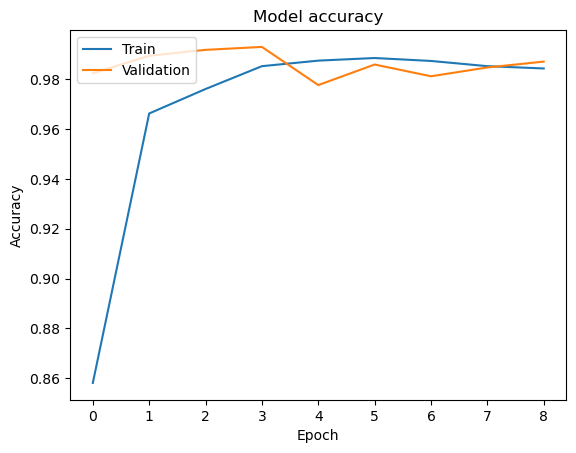

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'] )
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

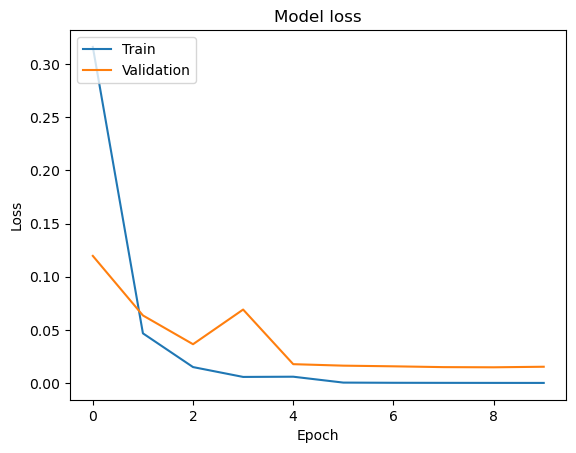

In [66]:

# Plot training & validation loss values
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'] )
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted exercise class: lat pulldown


Text(0.5, 1.0, 'lat pulldown')

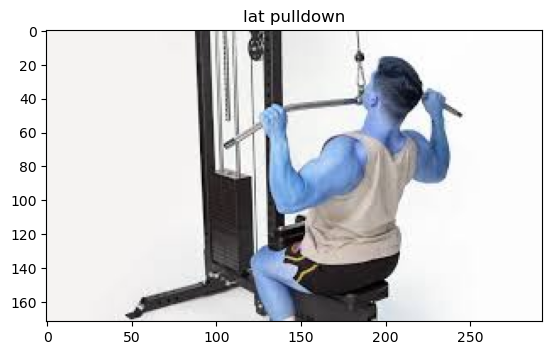

In [28]:
# Load and preprocess a custom input image for prediction
import matplotlib.pyplot as plt
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize to the same size as your training images
    img = img.astype('float32') / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 224, 224, 3)
    return img

# Function to make a prediction and decode the result
def predict_custom_image(image_path, model, label_encoder):
    img = preprocess_image(image_path)
    prediction = model.predict(img)  # Predict the class
    predicted_class_index = np.argmax(prediction, axis=1)  # Get index of the highest probability class
    predicted_class = label_encoder.inverse_transform(predicted_class_index)  # Convert index back to label
    return predicted_class[0]


custom_image_path = r'E:\aa.jpeg'  # Change this to your image path
a = cv2.imread(custom_image_path)
predicted_label = predict_custom_image(custom_image_path, model, le)
print(f'Predicted exercise class: {predicted_label}')
plt.imshow(a)
plt.title(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted exercise class: lateral raises


Text(0.5, 1.0, 'lateral raises')

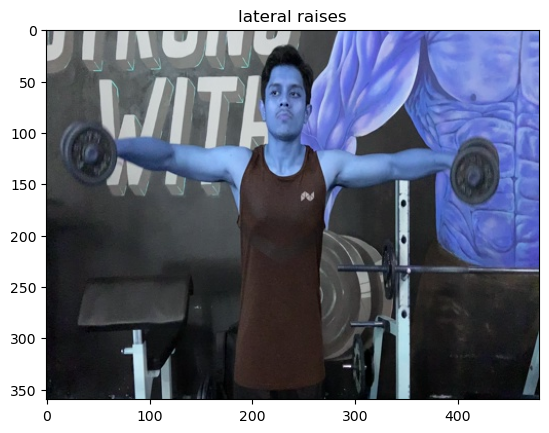

In [30]:
custom_image_path = r'E:\dataset\lateral curls\lat.jpg'  # Change this to your image path
a = cv2.imread(custom_image_path)
predicted_label = predict_custom_image(custom_image_path, model, le)
print(f'Predicted exercise class: {predicted_label}')
plt.imshow(a)
plt.title(predicted_label)

In [57]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load the saved model
model = load_model('exercise_pose_mobilenet.h5')

# Recompile the model (ensure you specify the same optimizer and loss used during training)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Load your test data (assuming you have the same test dataset setup)
data_path = r'E:\college\computer vision\case study\dataset\archive'
images = []
image_labels = []

labels = []
for folder in os.listdir(data_path):
    labels.append(folder)
labels.sort()
labels = labels[0:13]  # Limiting to 13 classes

for label in labels:
    folder_path = os.path.join(data_path, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        img = img.astype('float32') / 255.0  # Normalize
        images.append(img)
        image_labels.append(label)

# Convert to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

# Encoding labels into integers
label_encoder = LabelEncoder()
image_labels_encoded = label_encoder.fit_transform(image_labels)

# Convert labels to categorical (one-hot encoding)
image_labels_encoded = to_categorical(image_labels_encoded, num_classes=len(labels))

# Use the same train-test split as before
trainX, testX, trainY, testY = train_test_split(images, image_labels_encoded, test_size=0.2, random_state=42)

# Evaluate the model on the test data (This step ensures metrics are built and avoids warnings)
loss, accuracy = model.evaluate(testX, testY)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# # Predict class probabilities for the test set
# test_predictions = model.predict(testX)

# # Convert probabilities to class labels
# test_pred_labels = np.argmax(test_predictions, axis=1)
# true_labels = np.argmax(testY, axis=1)  # Get true class labels from one-hot encoding

# # Generate confusion matrix
# conf_matrix = confusion_matrix(true_labels, test_pred_labels)

# # Plot confusion matrix using seaborn for better visualization
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
# plt.show()

# # Classification report for precision, recall, and F1-score
# print(classification_report(true_labels, test_pred_labels, target_names=label_encoder.classes_))


54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - accuracy: 0.9903 - loss: 0.0198
Test Loss: 0.007752751931548119
Test Accuracy: 0.9958775043487549


In [58]:

model.evaluate(testX,testY)

54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.9903 - loss: 0.0198


[0.007752751931548119, 0.9958775043487549]

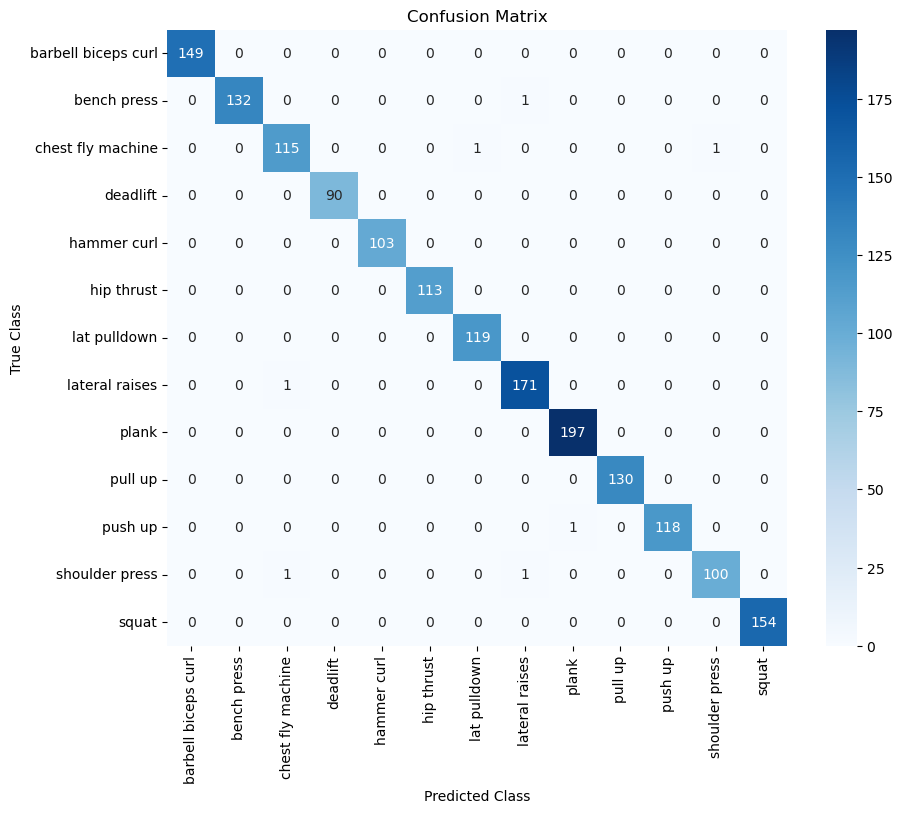

                     precision    recall  f1-score   support

barbell biceps curl       1.00      1.00      1.00       149
        bench press       1.00      0.99      1.00       133
  chest fly machine       0.98      0.98      0.98       117
           deadlift       1.00      1.00      1.00        90
        hammer curl       1.00      1.00      1.00       103
         hip thrust       1.00      1.00      1.00       113
       lat pulldown       0.99      1.00      1.00       119
     lateral raises       0.99      0.99      0.99       172
              plank       0.99      1.00      1.00       197
            pull up       1.00      1.00      1.00       130
            push up       1.00      0.99      1.00       119
     shoulder press       0.99      0.98      0.99       102
              squat       1.00      1.00      1.00       154

           accuracy                           1.00      1698
          macro avg       1.00      1.00      1.00      1698
       weighted avg   

In [61]:
test_pred_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(testY, axis=1)  # Get true class labels from one-hot encoding

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, test_pred_labels)

# Plot confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Classification report for precision, recall, and F1-score
print(classification_report(true_labels, test_pred_labels, target_names=label_encoder.classes_))

In [11]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import kagglehub

# Download latest version of the dataset using KaggleHub
dataset_path = kagglehub.dataset_download("hasyimabdillah/workoutexercises-images")

# Load the saved model
model = load_model('exercise_pose_mobilenet.h5')

# Recompile the model (ensure you specify the same optimizer and loss used during training)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Load your dataset
images = []
image_labels = []

# Get unique labels from the dataset directory
labels = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]
labels.sort()

# Load images and labels
for label in labels:
    folder_path = os.path.join(dataset_path, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip files that are not valid images
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        img = img.astype('float32') / 255.0  # Normalize
        images.append(img)
        image_labels.append(label)

# Convert to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

# Encoding labels into integers
label_encoder = LabelEncoder()
image_labels_encoded = label_encoder.fit_transform(image_labels)

# Convert labels to categorical (one-hot encoding)
image_labels_encoded = to_categorical(image_labels_encoded, num_classes=len(labels))

# Split the dataset into training, validation, and testing
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Split data: first into training and temp (validation + test)
trainX, tempX, trainY, tempY = train_test_split(images, image_labels_encoded, test_size=(val_ratio + test_ratio), random_state=42)

# Split temp into validation and testing
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(testX, testY)
print(f"Split Ratio: {train_ratio}-{val_ratio}-{test_ratio} => Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predict class probabilities for the test set
test_predictions = model.predict(testX)

# Check shapes
print("True labels shape:", testY.shape)
print("Predictions shape:", test_predictions.shape)

# Convert probabilities to class labels
test_pred_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(testY, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, test_pred_labels)

# Plot confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Classification report for precision, recall, and F1-score
print(classification_report(true_labels, test_pred_labels, target_names=label_encoder.classes_))


100%|████████████████████████████████████████████████████████████████████████████████| 818M/818M [16:48<00:00, 851kB/s]

Extracting files...


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 22), output.shape=(None, 13)